## Mandatory Task

In [3]:
#Importing required packages!
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from IPython.core.display import display, HTML 
import re
import folium
import pymongo
import json
from pymongo import MongoClient


In [4]:
#Importing data and resize it!
total_crime = pd.read_csv('/home/master/Escritorio/CLASS1/Map_of_Police_Department_Incidents.csv')
print(total_crime.shape)

#I use 10% of the data because of memory issues.
seed=1
s_crime = total_crime.sample(frac=0.10,random_state=seed)
del(total_crime) #delete pandas dataframe from memory


(2133457, 12)


In [5]:
#Transfroming date from string to date type and delta date for future analysis
date = pd.to_datetime(s_crime["Date"])
print(date.min())
print(date.max())

#Create a new column days with timedelta format
t_delta = (date-date.min()).astype("timedelta64[D]")
s_crime["days"] = t_delta
s_crime.head(1)

2003-01-01 00:00:00
2017-10-15 00:00:00


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,days
659927,66046206,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,07/11/2006 12:00:00 AM,21:00,MISSION,NONE,20TH ST / CHURCH ST,-122.428052,37.75809,"(37.7580899767786, -122.428051707644)",1287.0


In [6]:
# Plotting bargraph
def plotdat(data,cat):
    l=data.groupby(cat).size()
    s=l.sort_values(ascending=True)
    plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    s.plot(kind='bar',fontsize=12,color='b', )
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

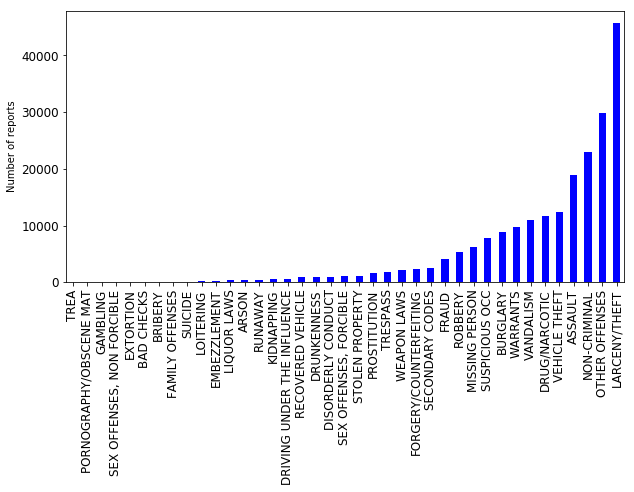

In [7]:
plotdat(s_crime,"Category")

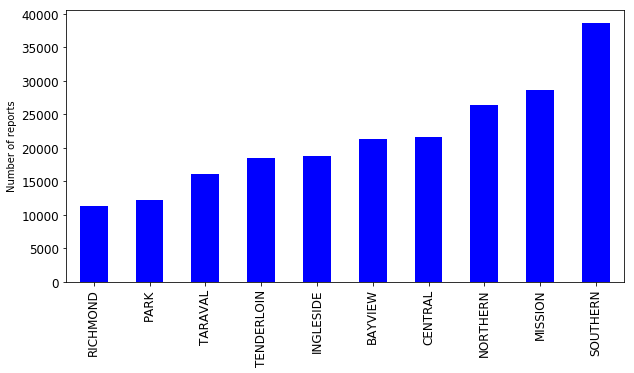

In [8]:
plotdat(s_crime,"PdDistrict")

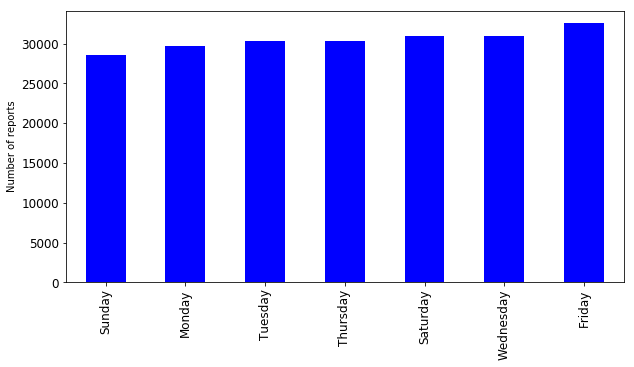

In [9]:
plotdat(s_crime,"DayOfWeek")

In [10]:

# Heatmap and hierarchical clustering
def types_districts(d_crime,per):    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)

    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)

    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]

    return t

In [11]:
tp=types_districts(s_crime,95)

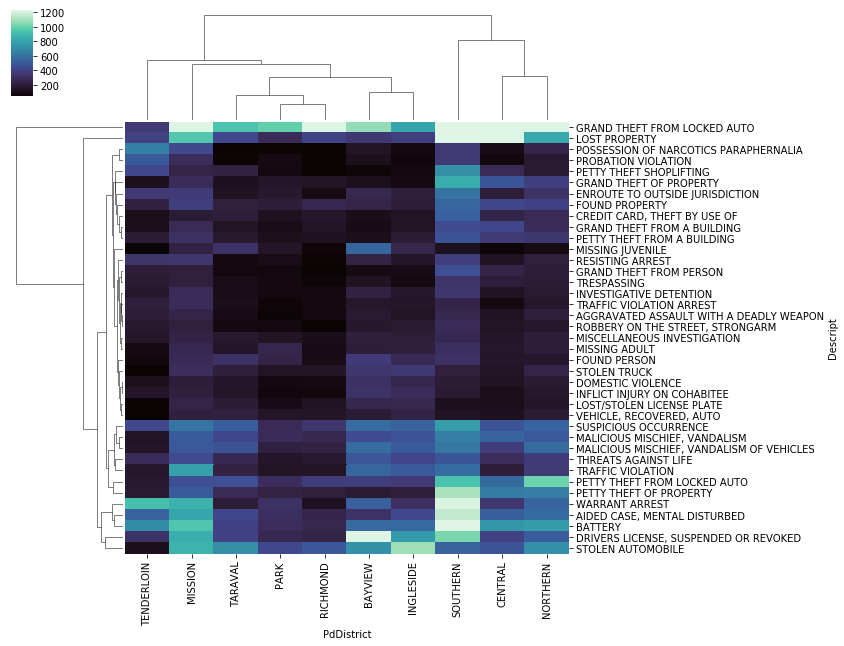

In [12]:
sns.clustermap(tp,cmap="mako", robust=True) 

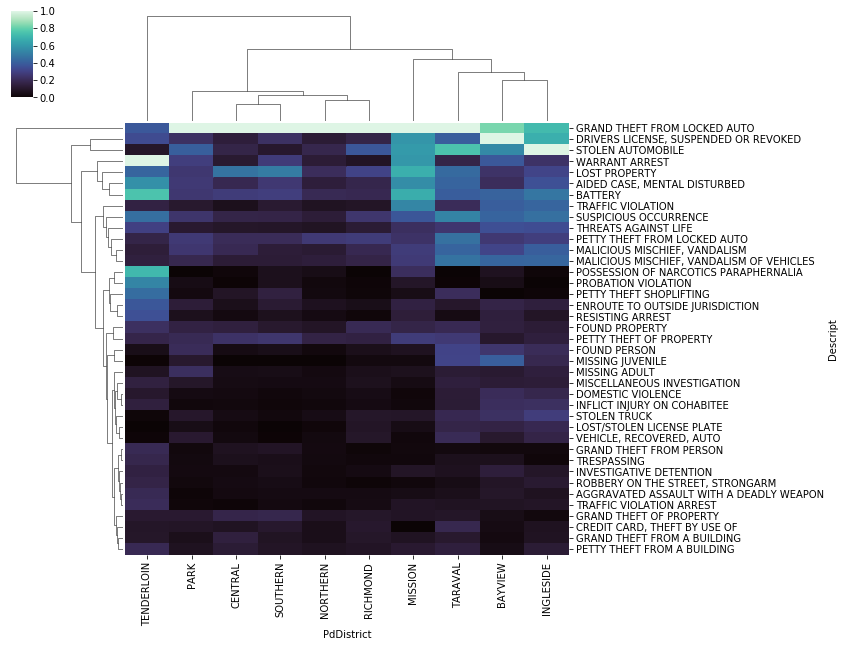

In [13]:
sns.clustermap(tp,standard_scale=1,cmap="mako", robust=True) 

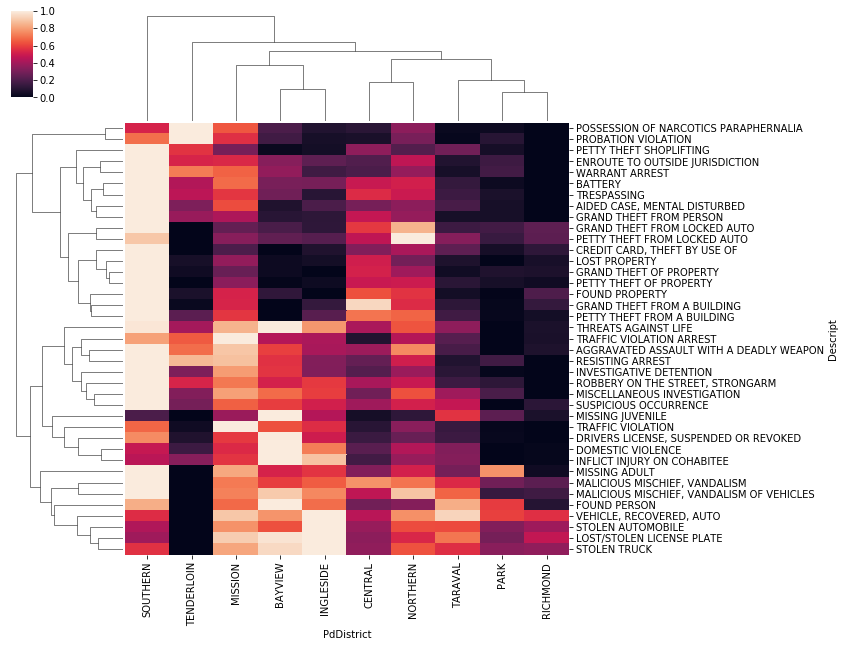

In [14]:
sns.clustermap(tp,standard_scale=0) 

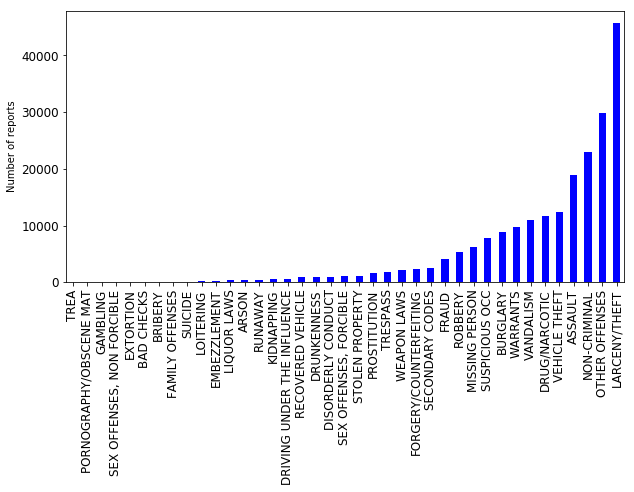

In [15]:
plotdat(s_crime,'Category')

In [16]:
##In order to choose incident,connecting to the mongodb
print("Mongo version",pymongo.__version__)
client = MongoClient("localhost",27017)
db = client.test
collection = db.crime_san_francisco

Mongo version 3.10.1


In [17]:
#just in case
collection.drop()

In [18]:
records = json.loads(s_crime.to_json(orient ="records"))
collection.delete_many({}) #just in case
collection.insert_many(records)

In [19]:
cursor = collection.find().sort("Category",pymongo.ASCENDING).limit(10)
for doc in cursor:
    #print(doc)
    print(doc["Descript"])

ARSON
ARSON OF A VEHICLE
ARSON OF A VEHICLE
FIRE, UNLAWFULLY CAUSING
ARSON OF A COMMERCIAL BUILDING
ARSON
ARSON
ARSON OF A VEHICLE
ARSON OF A VEHICLE
ARSON OF A VEHICLE


In [20]:
#Establishing a pipeline to select all rows matching attribute
pipeline = [
        {"$match" : {"Category" : "LARCENY/THEFT" }}
        ]

aggResult = collection.aggregate(pipeline)
df2 = pd.DataFrame(list(aggResult))
df2.head()

,Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,Resolution,Time,X,Y,_id,days
0,20TH ST / CHURCH ST,LARCENY/THEFT,07/11/2006 12:00:00 AM,Tuesday,GRAND THEFT FROM LOCKED AUTO,66046206,"(37.7580899767786, -122.428051707644)",MISSION,NONE,21:00,-122.428052,37.758090,5e2727a672e5a8f4837e16d6,1287.0
1,0 Block of TURK ST,LARCENY/THEFT,03/11/2012 12:00:00 AM,Sunday,PETTY THEFT FROM A BUILDING,120202043,"(37.7833862379382, -122.409853729941)",TENDERLOIN,NONE,12:00,-122.409854,37.783386,5e2727a672e5a8f4837e16e6,3357.0
2,ILLINOIS ST / 20TH ST,LARCENY/THEFT,01/16/2015 12:00:00 AM,Friday,GRAND THEFT FROM LOCKED AUTO,156032226,"(37.7605499565144, -122.387571306252)",BAYVIEW,NONE,18:30,-122.387571,37.760550,5e2727a672e5a8f4837e16ed,4398.0
3,0 Block of MASON ST,LARCENY/THEFT,07/23/2017 12:00:00 AM,Sunday,PETTY THEFT FROM A BUILDING,170599486,"(37.78380666314242, -122.40912963366864)",TENDERLOIN,NONE,14:00,-122.409130,37.783807,5e2727a672e5a8f4837e16ee,5317.0
4,WILLOW ST / VANNESS AV,LARCENY/THEFT,05/05/2012 12:00:00 AM,Saturday,PETTY THEFT FROM LOCKED AUTO,120358884,"(37.7833601835095, -122.420906514954)",NORTHERN,NONE,21:50,-122.420907,37.783360,5e2727a672e5a8f4837e16f1,3412.0


In [21]:
collection.find({"Category" : "LARCENY/THEFT"}).count()

/home/master/Aplicaciones/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


45631

In [22]:
#Having a look at descriptions
c=df2['Descript'].value_counts()
c.sort_values(ascending=False)
c.head(10)  

GRAND THEFT FROM LOCKED AUTO      16811
PETTY THEFT FROM LOCKED AUTO       5070
PETTY THEFT OF PROPERTY            4273
GRAND THEFT OF PROPERTY            2791
PETTY THEFT FROM A BUILDING        2474
PETTY THEFT SHOPLIFTING            2383
GRAND THEFT FROM A BUILDING        2207
GRAND THEFT FROM PERSON            1713
GRAND THEFT FROM UNLOCKED AUTO     1358
GRAND THEFT PICKPOCKET             1336
Name: Descript, dtype: int64

In [23]:
# Organize incidents' descriptions versus Districts where they were detected
def types_districts(s_crime,per):
        # Group by crime type and district 
    hoods_per_type=s_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [24]:
t=types_districts(df2,75)

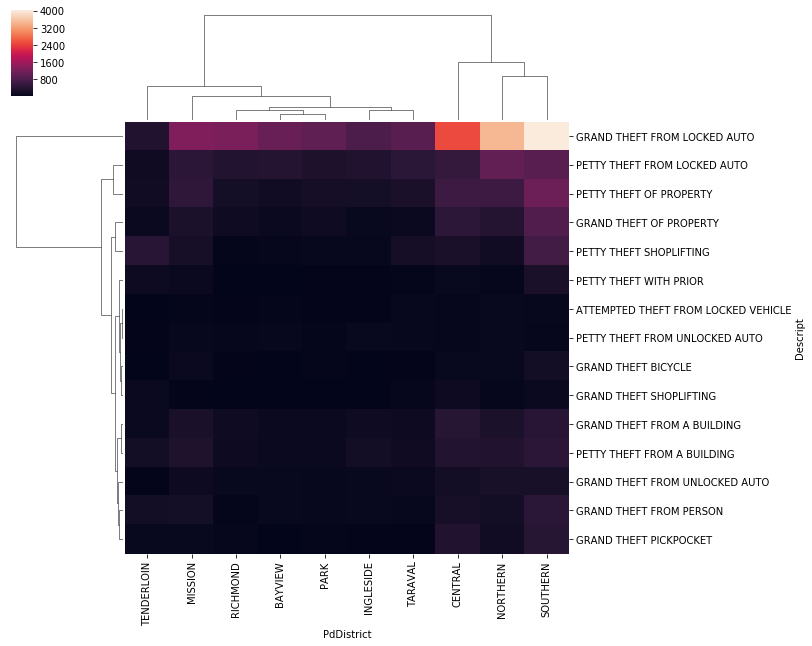

In [25]:
sns.clustermap(t)

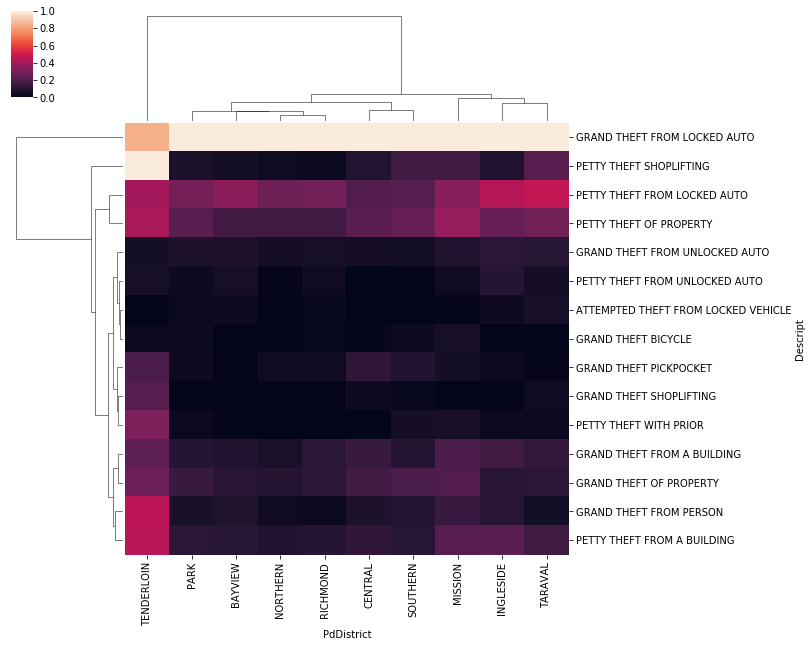

In [26]:
sns.clustermap(t,standard_scale=1)

In [27]:
## grand theft from locked auto is the most common theft description 

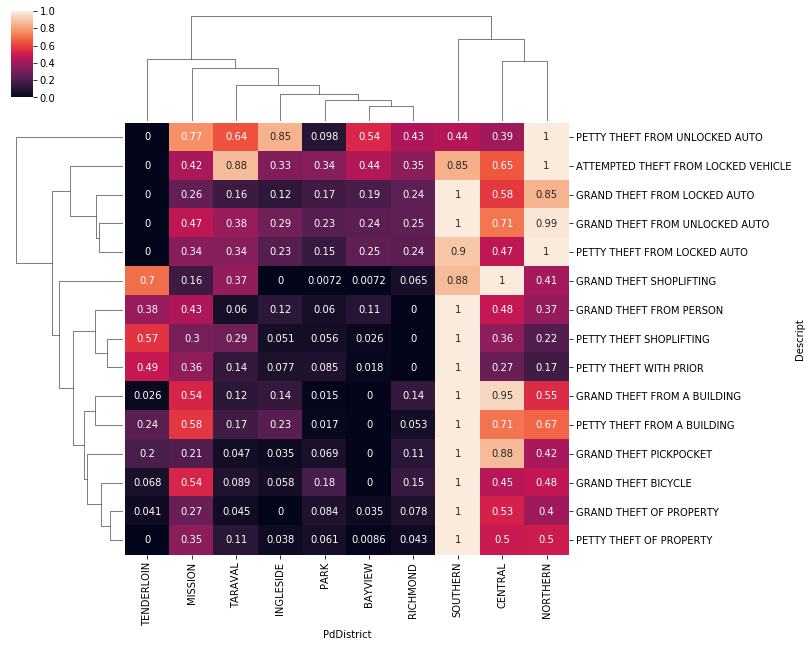

In [28]:
sns.clustermap(t,standard_scale=0, annot=True)

In [29]:
##southern is the one where many theft descriptions are common

In [30]:
##################################################### Time Series Analysis #############################################
df2['Month']=np.floor(df2["days"]/30) # Approximate month (30 day window)

# Default
district='All'

def timeseries(dat,per):
    ''' Category grouped by month '''    
    # Group by crime type and district 
    cat_per_time=dat.groupby('Month').Descript.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
  
    # Filter by crime per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]    
    return t

In [31]:
t_all=timeseries(df2,5) 

In [32]:
#Find incidents descriptions related to spedific word patter 
def descriptionsAccordingToPattern(pattern):
    pat = re.compile(pattern, re.I)
    pipeline = [
            {"$match": {"Category":"LARCENY/THEFT" , 'Descript': {'$regex': pat}}},
    ]

    aggResult = collection.aggregate(pipeline)
    df3 = pd.DataFrame(list(aggResult))
    drug = df3.groupby('Descript').size()
    s = pd.Series(drug)
    s = s[s != 1] # filter those descriptions with value less equal 1
    features = list(s.index)
    return features

In [33]:
lockedauto_features = descriptionsAccordingToPattern('LOCKED AUTO')
property_features = descriptionsAccordingToPattern('PROPERTY')
building_features = descriptionsAccordingToPattern('BUILDING')
unlockedauto_features = descriptionsAccordingToPattern('UNLOCKED AUTO')
pickpocket_features = descriptionsAccordingToPattern('PICKPOCKET')
person_features = descriptionsAccordingToPattern('PERSON')

In [34]:
# Lets use real dates for plotting
days_from_start=pd.Series(t_all.index*30).astype('timedelta64[D]')
dates_for_plot=date.min()+days_from_start
time_labels=dates_for_plot.map(lambda x: str(x.year)+'-'+str(x.month))

In [35]:
# Analytics per drug tipology according to descriptions
def theft_analysis(t,district,plot):
    t['LOCKED AUTO']=t[lockedauto_features].sum(axis=1)
    t['PROPERTY']=t[property_features].sum(axis=1)
    t['BUILDING']=t[building_features].sum(axis=1)
    t['UNLOCKED AUTO']=t[unlockedauto_features].sum(axis=1)
    t['PICKPOCKET']=t[pickpocket_features].sum(axis=1)
    t['PERSON']=t[person_features].sum(axis=1)
    thefts=t[['LOCKED AUTO','PROPERTY','BUILDING','UNLOCKED AUTO','PICKPOCKET','PERSON']]
    if plot:
        thefts.index=[int(i) for i in thefts.index]
        colors = plt.cm.jet(np.linspace(0, 1, thefts.shape[1]))
        thefts.plot(kind='bar', stacked=True, figsize=(20,5), color=colors, width=1, title=district,fontsize=6)
    return thefts

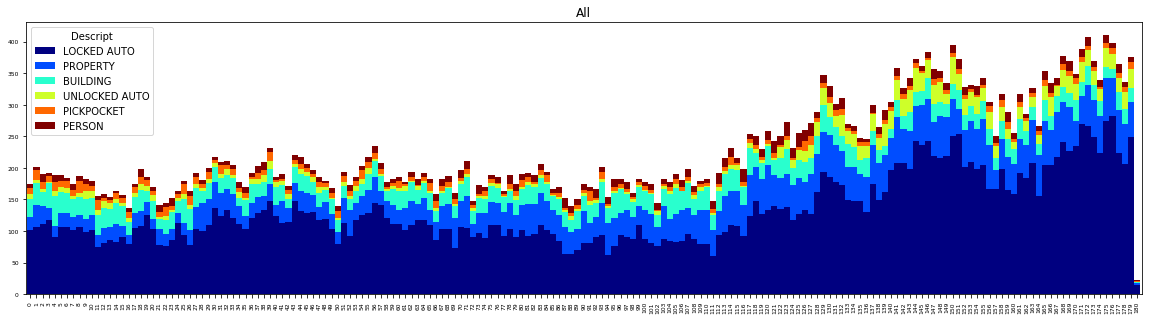

In [36]:
theft_df_all=theft_analysis(t_all,district,True)

In [37]:
def theft_analysis_rescale(t,district,plot):
    t['LOCKED AUTO']=t[lockedauto_features].sum(axis=1)
    t['PROPERTY']=t[property_features].sum(axis=1)
    t['BUILDING']=t[building_features].sum(axis=1)
    t['UNLOCKED AUTO']=t[unlockedauto_features].sum(axis=1)
    t['PICKPOCKET']=t[pickpocket_features].sum(axis=1)
    t['PERSON']=t[person_features].sum(axis=1)
    thefts=t[['LOCKED AUTO','PROPERTY','BUILDING','UNLOCKED AUTO','PICKPOCKET','PERSON']]
    if plot:
        thefts=thefts.div(thefts.sum(axis=1),axis=0)
        thefts.index=[int(i) for i in thefts.index]
        colors = plt.cm.GnBu(np.linspace(0, 1, thefts.shape[1]))
        colors = plt.cm.jet(np.linspace(0, 1, thefts.shape[1]))
        thefts.plot(kind='bar', stacked=True, figsize=(20,5), color=colors, width=1, title=district, legend=True)
        plt.ylim([0,1])
    return thefts

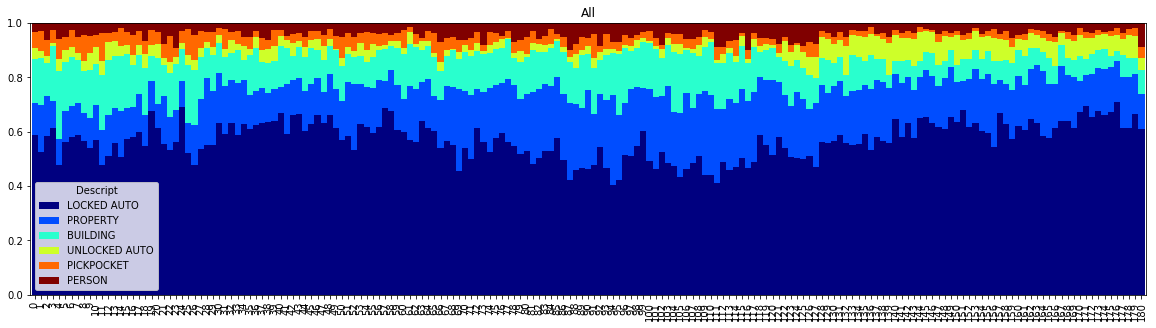

In [38]:
theft_df_all=theft_analysis_rescale(t_all,district,True)

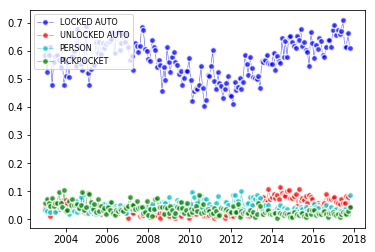

In [39]:
##################################################### Focussing on real dates and Districts #############################################
# Adding the real dates andfocusing on several types of thefts
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['LOCKED AUTO','UNLOCKED AUTO','PERSON','PICKPOCKET'],['b','r','c','g']):
    plt.plot(dates_for_plot.index,theft_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

dates_for_plot.index=dates_for_plot

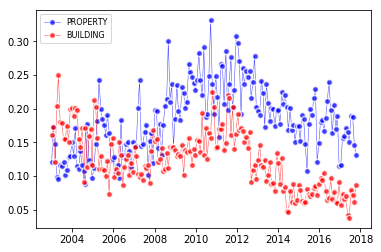

In [40]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['PROPERTY','BUILDING'],['b','r']):
    plt.plot(dates_for_plot.index,theft_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

dates_for_plot.index=dates_for_plot

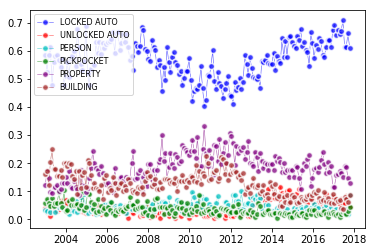

In [41]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['LOCKED AUTO','UNLOCKED AUTO','PERSON','PICKPOCKET','PROPERTY','BUILDING'],['b','r','c','g',"purple","brown"]):
    plt.plot(dates_for_plot.index,theft_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

dates_for_plot.index=dates_for_plot

#locked auto is the most common way of thief.

/home/master/Aplicaciones/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


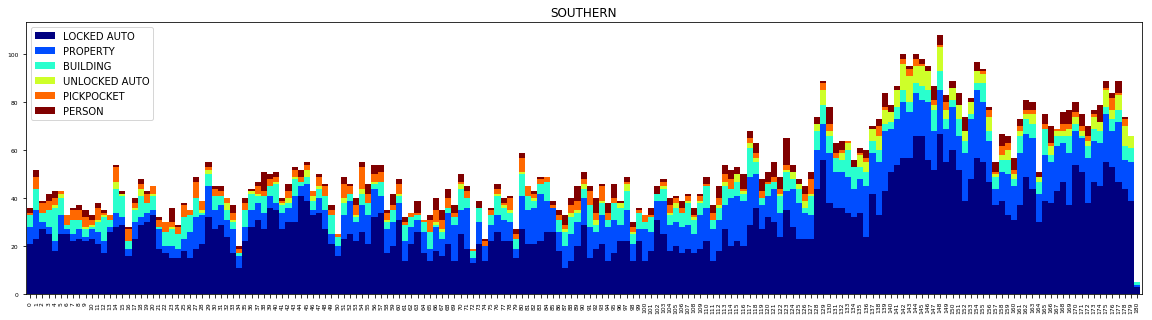

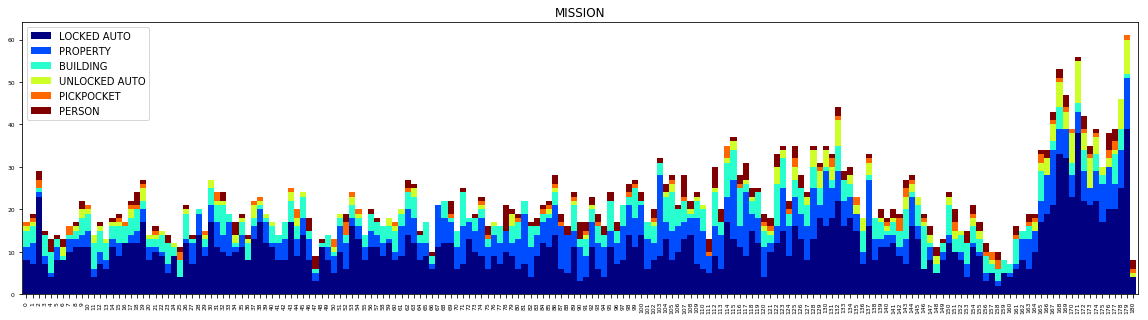

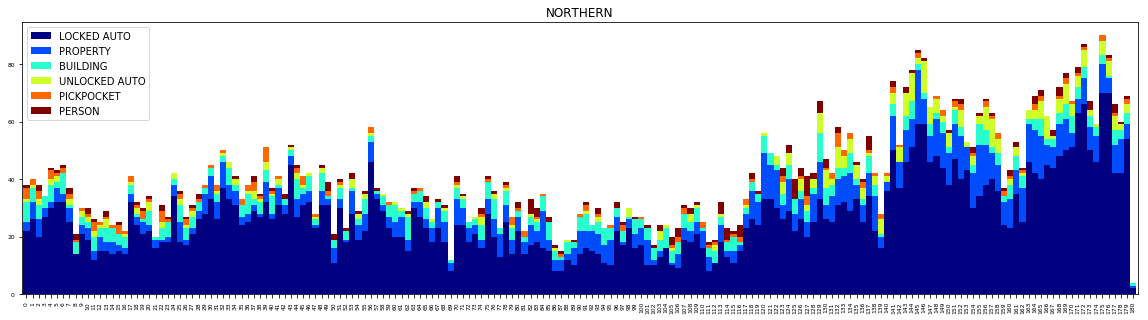

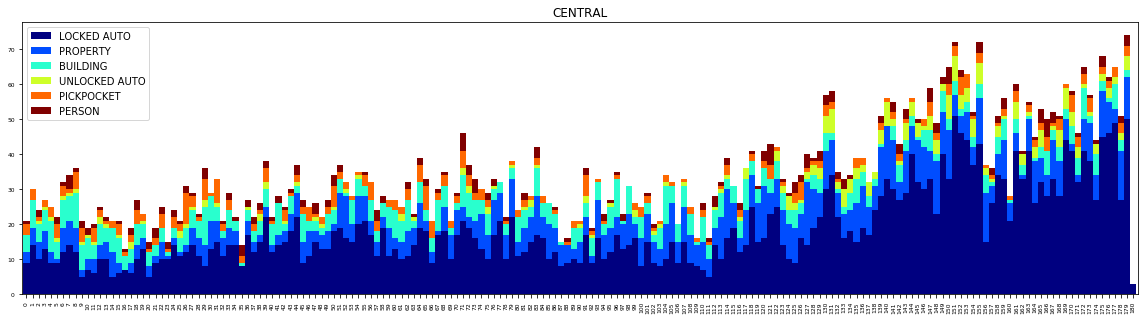

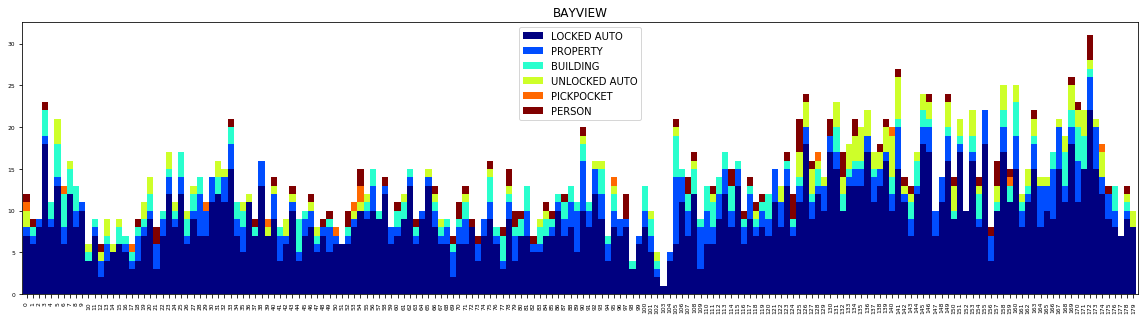

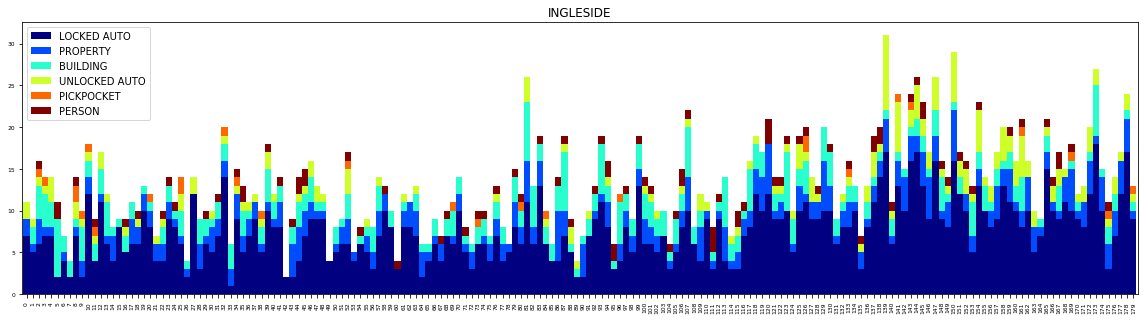

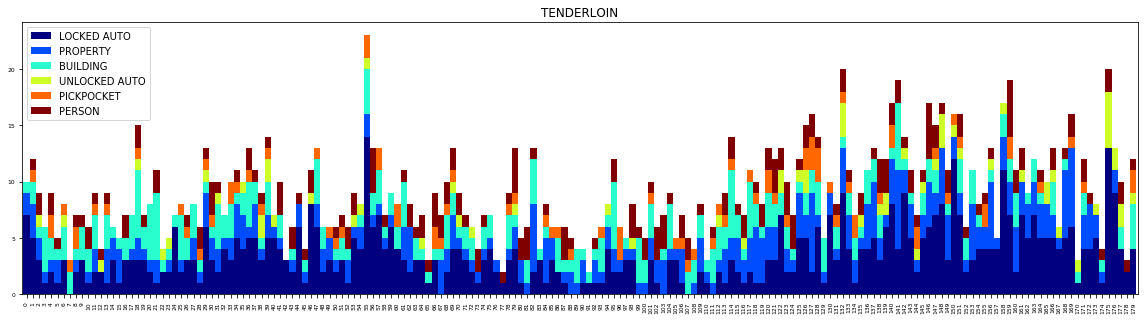

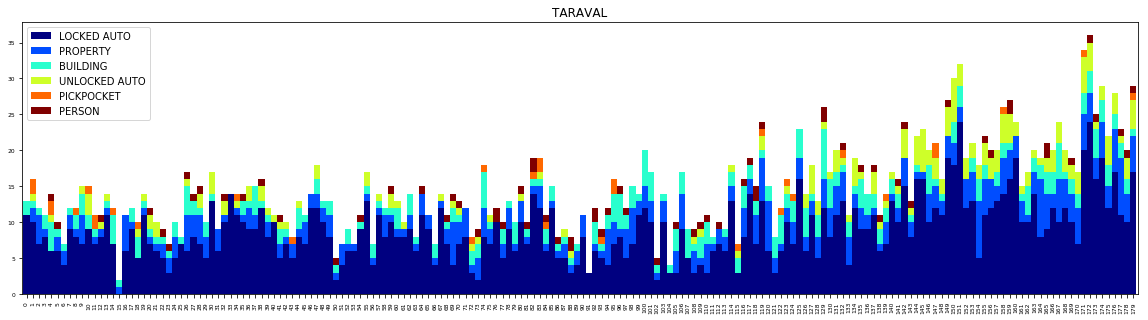

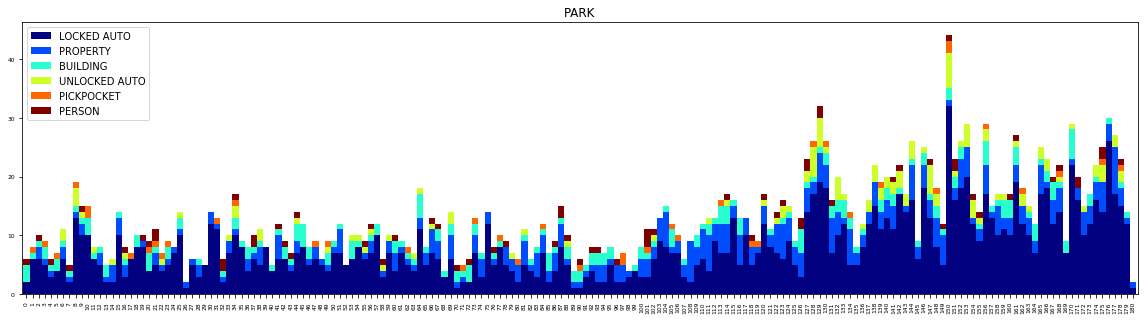

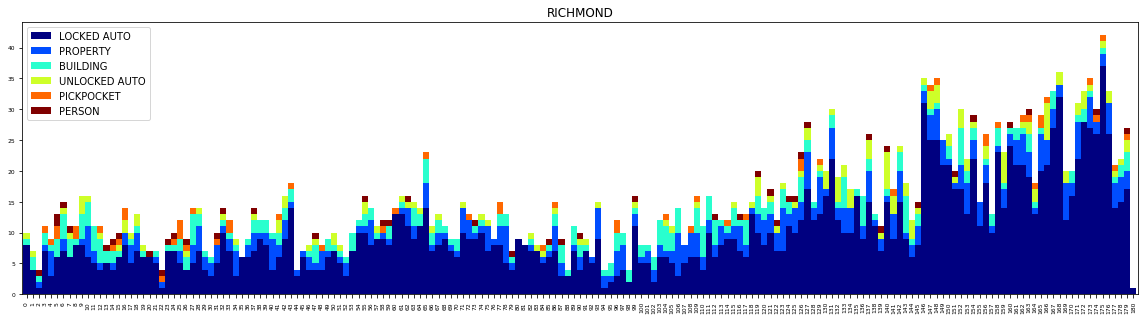

In [42]:
stor=[]
stor_time=[]

for d in s_crime['PdDistrict'].value_counts().index:
    # Specify district and group by time
        dist_dat=df2[df2['PdDistrict']==d]
        t=timeseries(dist_dat,10)
        # Merge to ensure all categories are preserved!
        t_merge=pd.DataFrame(columns=t_all.columns)
        m=pd.concat([t_merge,t],axis=0).fillna(0)
        m.reset_index(inplace=True)
        # Plot
        theft_df=theft_analysis(m,d,True)
        plt.show()
        s=theft_df.sum(axis=0)
        stor=stor+[s]
        theft_df.columns=cols=[c+"_%s"%d for c in theft_df.columns]
        stor_time=stor_time+[theft_df]    

theft_dat_time=pd.concat(stor_time,axis=1)
theft_dat=pd.concat(stor,axis=1)
theft_dat.columns=[s_crime['PdDistrict'].value_counts().index]
        

/home/master/Aplicaciones/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


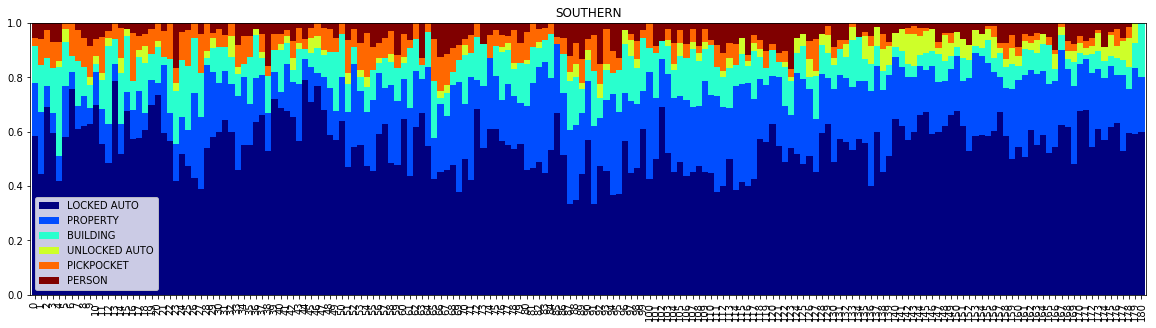

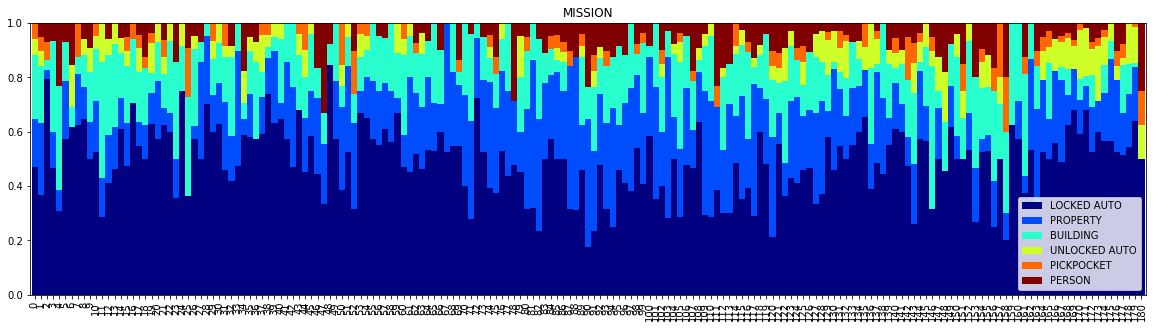

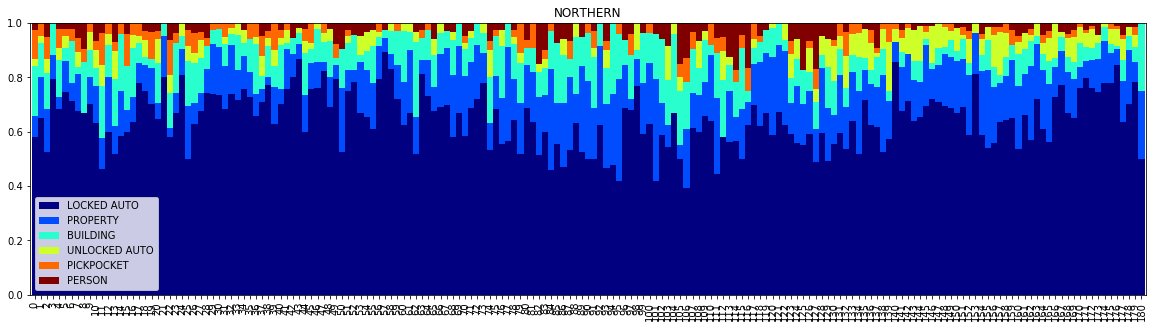

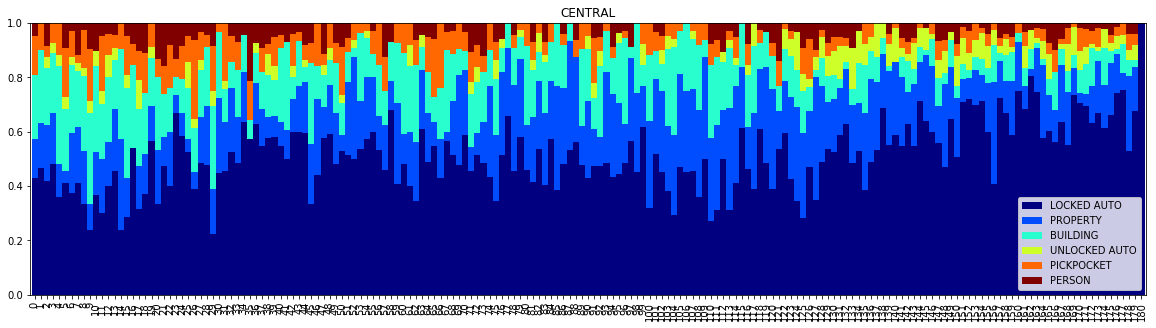

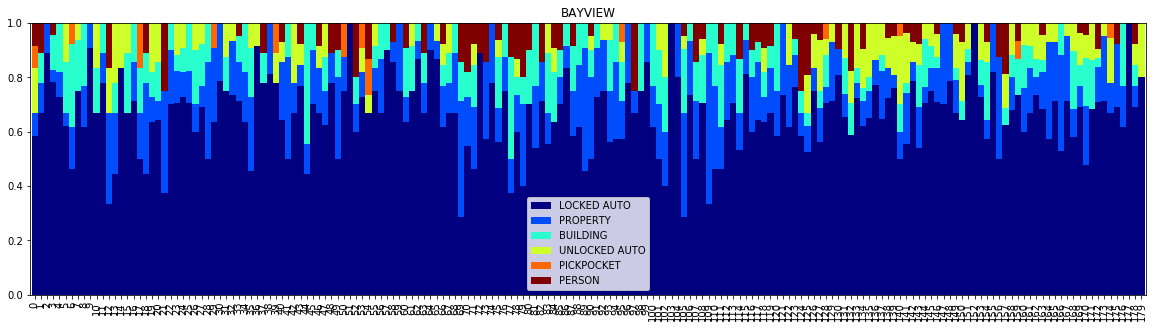

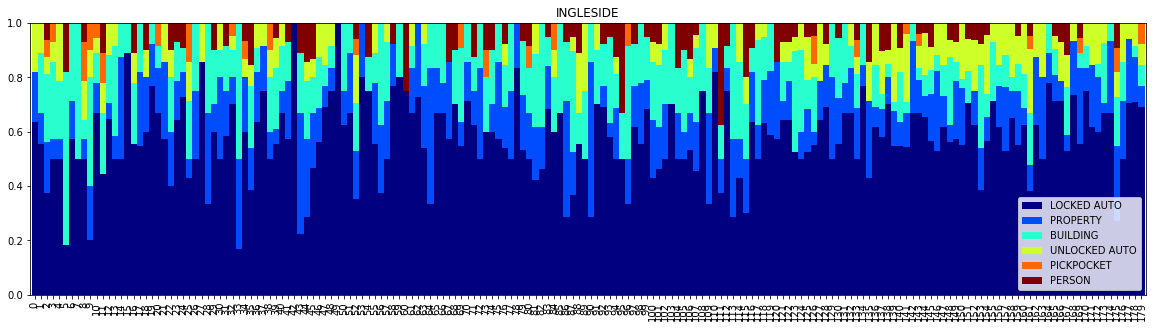

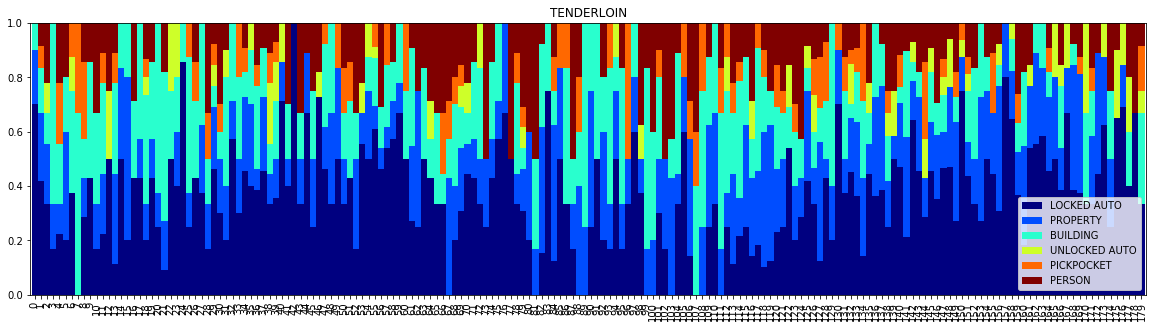

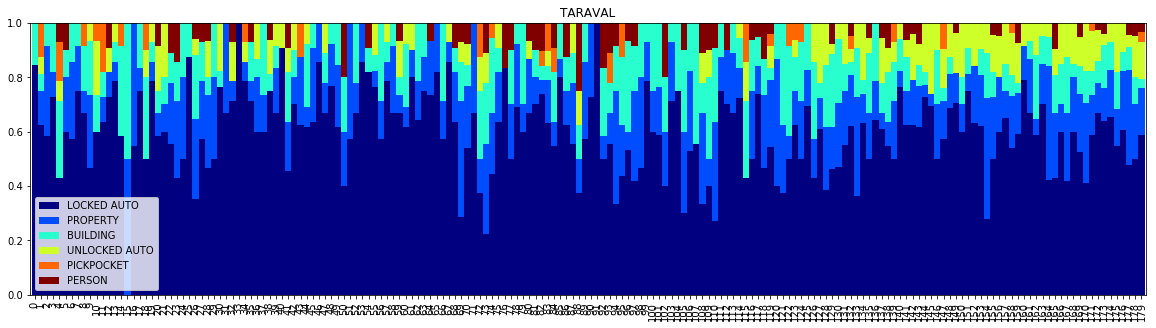

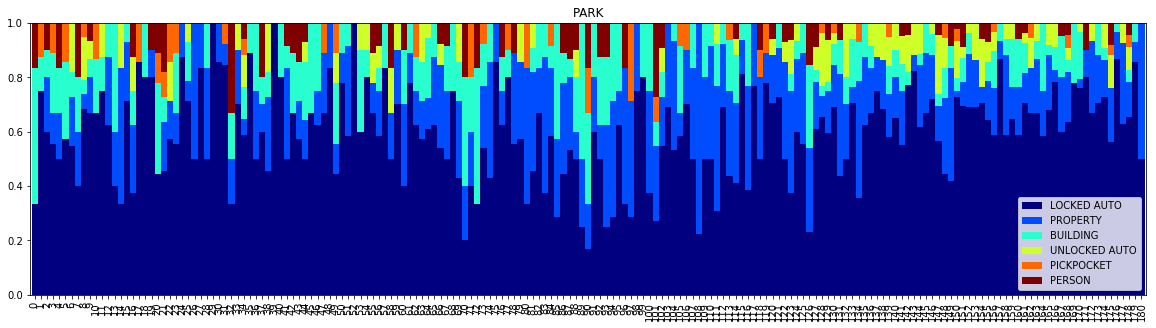

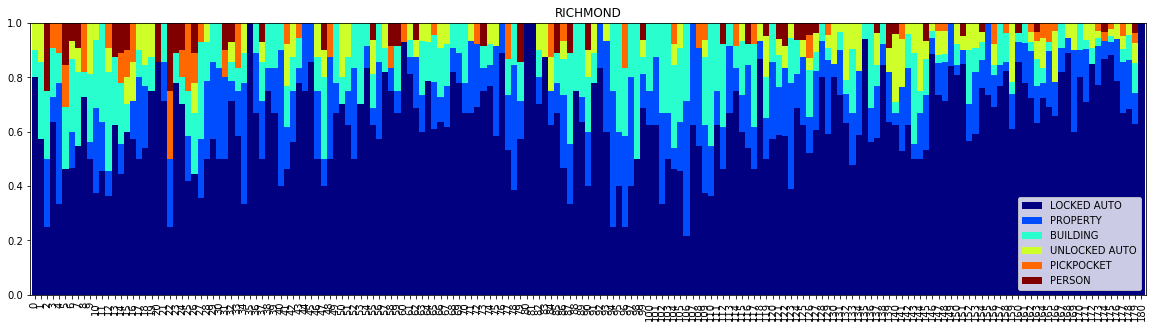

In [43]:
######################################################### Spatial relationships -################################################
#Let's re-do what we did above, but re-scale it.

stor=[]
stor_time=[]

for d in s_crime['PdDistrict'].value_counts().index:
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,0)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    theft_df=theft_analysis_rescale(m,d,True)
    plt.show()
    s=theft_df.sum(axis=0)
    stor=stor+[s]
    theft_df.columns=cols=[c+"_%s"%d for c in theft_df.columns]
    stor_time=stor_time+[theft_df]

#rates of thieft of locked auto is significantly less in Tenderloin where people thieft is more common compare the other cities.

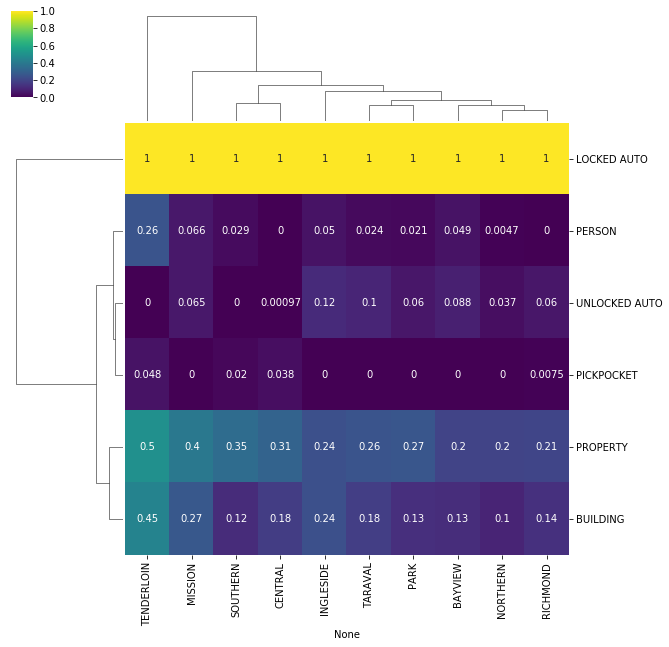

In [44]:
#We can now summarize this data using clustered heatmaps.
sns.clustermap(theft_dat,standard_scale=1,cmap="viridis",robust=True,annot=True)

In [45]:
tmp=df2.copy()
tmp.set_index('Descript',inplace=True)

crack_dat=tmp.loc[lockedauto_features]
crack_pts=crack_dat[['X','Y','Month']]

In [46]:
#Plot the crack regimes.
d=pd.DataFrame(crack_pts.groupby('Month').size())
d.index=dates_for_plot
d.columns=['Count']
diff=len(d.index)-140

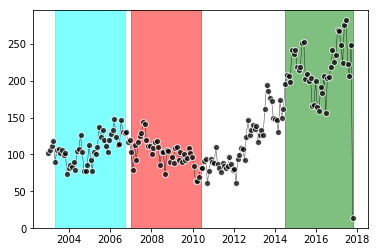

In [47]:
plt.plot(d.index,d['Count'],'o-',color='k',ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.axvspan(d.index[45-diff],d.index[45],color='cyan',alpha=0.5)
plt.axvspan(d.index[90-diff],d.index[90],color='red',alpha=0.5)
plt.axvspan(d.index[140],d.index[-1],color='green',alpha=0.5)

In [48]:
oldest_crack_sums=d.loc[(d.index>d.index[45-diff]) & (d.index<d.index[45])]
old_crack_sums=d.loc[(d.index>d.index[90-diff]) & (d.index<d.index[90])]
new_crack_sums=d.loc[d.index>d.index[140]]

In [49]:
#Fold-difference in mean between the two regimes.
old_crack_sums['Count'].mean()/float(new_crack_sums['Count'].mean())

0.4797313221777045

In [50]:
#Two regimes.
oldest_crack=crack_pts[(crack_pts['Month']>(45-diff)) & (crack_pts['Month']<45)]
oldest_crack.columns=['longitude','latitude','time']
old_crack=crack_pts[(crack_pts['Month']>(90-diff)) & (crack_pts['Month']<90)]
old_crack.columns=['longitude','latitude','time']
new_crack=crack_pts[crack_pts['Month']>140]
new_crack.columns=['longitude','latitude','time']

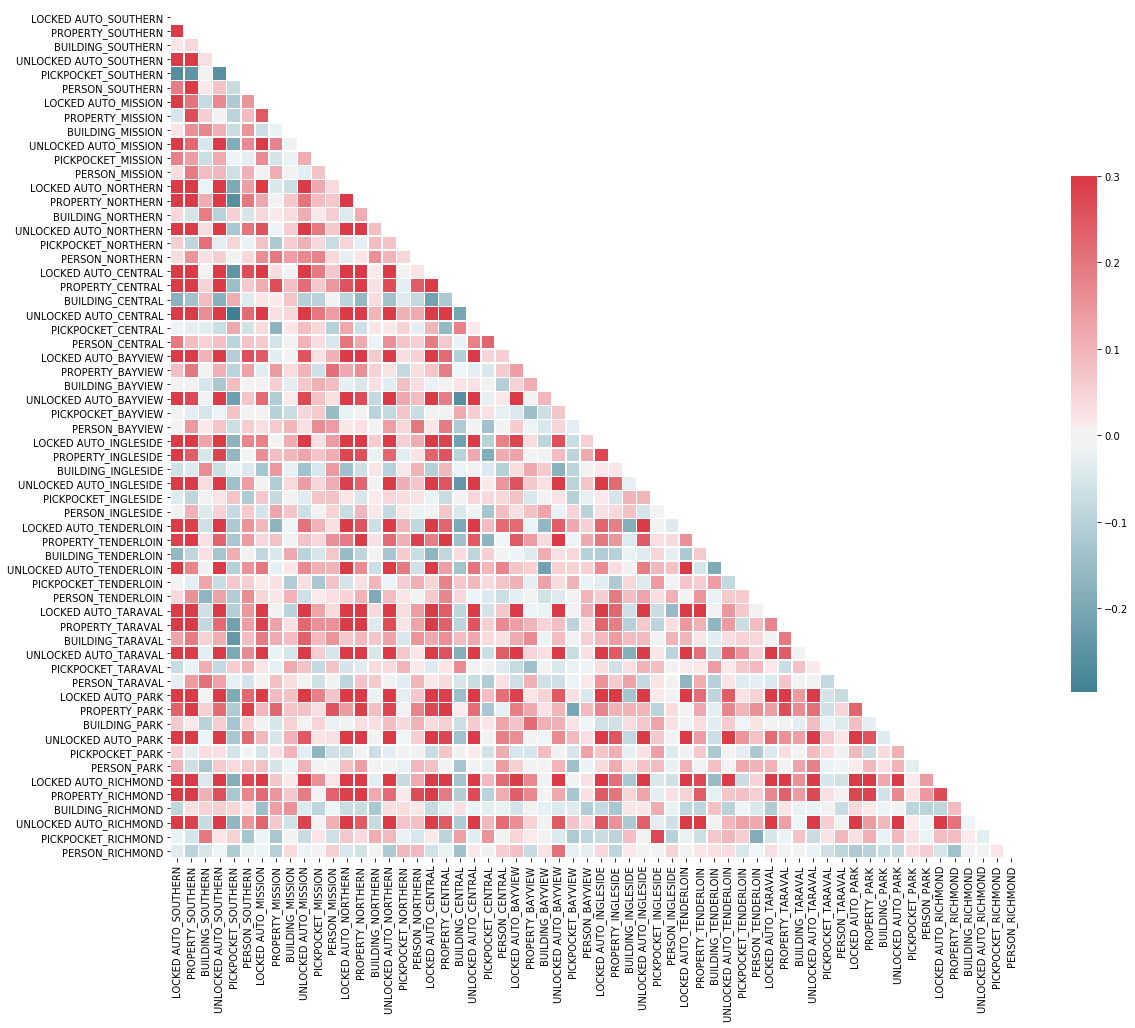

In [51]:
########################################################### Correlation Analysis ##############################################
#Having a look at correlations between areas for different theft descriptions.

sns.set_context(rc={"figure.figsize": (20,20)})
corr = theft_dat_time.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(19, 19))

# Generate a custom diverging colormap
sns.set_context(rc={"figure.figsize": (20,20)})
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,  mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5})


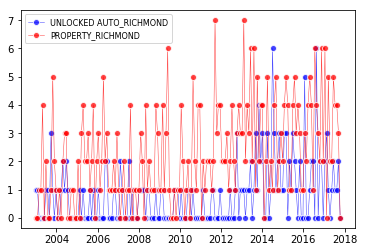

In [52]:
########################################################### Correlation Analysis ##############################################

#With this in mind, we can examine select timeseries data.

theft_dat_time.index=dates_for_plot.head(181)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['UNLOCKED AUTO_RICHMOND','PROPERTY_RICHMOND'],['b','r']):
    plt.plot(theft_dat_time.index,theft_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


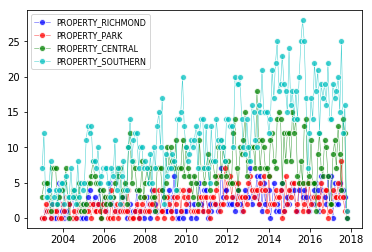

In [53]:
theft_dat_time.index=dates_for_plot.head(181)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['PROPERTY_RICHMOND','PROPERTY_PARK','PROPERTY_CENTRAL','PROPERTY_SOUTHERN'],['b','r','g','c']):
    plt.plot(theft_dat_time.index,theft_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)

plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

# Advanced Task

In [54]:
#Creating MongoBD collections to manage and query data
col1 = db.theft1
col2 = db.theft2

In [55]:
#Importing data into the database
col1.drop()
col2.drop()

In [56]:
# Collection for new crack
data_json1 = json.loads(new_crack.to_json(orient='records'))
col1.delete_many({})
col1.insert_many(data_json1)

In [57]:
# Collection for old crack
data_json2 = json.loads(old_crack.to_json(orient='records'))
col2.delete_many({})
col2.insert_many(data_json2)

In [58]:
cursor = col1.find().sort('time',pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e27283272e5a8f48381585f'), 'longitude': -122.4034047915, 'latitude': 37.7754207067, 'time': 141.0}
{'_id': ObjectId('5e27283272e5a8f483815865'), 'longitude': -122.3961640585, 'latitude': 37.7762328753, 'time': 141.0}
{'_id': ObjectId('5e27283272e5a8f483815868'), 'longitude': -122.4204689173, 'latitude': 37.8019448218, 'time': 141.0}


In [59]:
cursor2 = col2.find().sort('time',pymongo.ASCENDING).limit(10)
for doc in cursor2:
    print(doc)

{'_id': ObjectId('5e27283272e5a8f483817a68'), 'longitude': -122.4653521991, 'latitude': 37.7819129193, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817a88'), 'longitude': -122.4562958465, 'latitude': 37.781380088, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817acc'), 'longitude': -122.3918621297, 'latitude': 37.7893703017, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817afd'), 'longitude': -122.4142009957, 'latitude': 37.7137889657, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817b05'), 'longitude': -122.4415592628, 'latitude': 37.7620486897, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817b21'), 'longitude': -122.4054271628, 'latitude': 37.7712969876, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817b3e'), 'longitude': -122.4179644838, 'latitude': 37.7586968166, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817b44'), 'longitude': -122.4155778098, 'latitude': 37.7695914544, 'time': 50.0}
{'_id': ObjectId('5e27283272e5a8f483817b4c'), 'longitude': -122.4

In [60]:
# Create a new collection to store districts geo points
col3 = db.districts
col3.drop()

In [61]:
os.system('/snap/mongo32/2/bin/mongoimport -d test -c districts --file /home/master/Escritorio/CLASS1/Analysis_Neighborhoods.geojson')

0

In [62]:
cursor3 = col3.find().limit(1)
for doc in cursor3:
    print(doc)

{'_id': ObjectId('5e272833a14c261670337d0a'), 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'nhood': 'Bayview Hunters Point'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.38157774241415, 37.75307043091241], [-122.38156949251606, 37.753060959298274], [-122.38159239626694, 37.75309424492931], [-122.38155614326205, 37.753045901366754], [-122.38155137472305, 37.75304127677009], [-122.38154650687193, 37.753036719547374], [-122.3815415385967, 37.75303223061754], [-122.38153647334677, 37.75302781172802], [-122.38153131112232, 37.75302346287867], [-122.38152605423795, 37.753019185835115], [-122.38152070389688, 37.75301498328154], [-122.38151526236827, 37.75301085518192], [-122.38150973196667, 37.75300680330162], [-122.38150411158058, 37.75300282855954], [-122.38149840577098, 37.7529989317842], [-122.38149261460651, 37.75299511567804], [-122.38148674033339, 37.75299137930393], [-122.38148078528907, 37.75298772532827], [-122.38147475063121, 37.7529

In [63]:
# Getting information about the index
col2.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)], 'ns': 'test.theft2'}}

In [64]:
#Preparing data to perform spatial queries by Mongo
col_temp = db.theft3
cursor = col2.find()
for doc in cursor:
    col_temp.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    })

In [65]:
cursor = col_temp.find_one()
cursor

{'_id': ObjectId('5e25ad14c01cbb798aa46321'),
 'loc': {'type': 'Point', 'coordinates': [-122.4017275906, 37.7654693887]}}

In [66]:
cursor2 = col2.find_one()  
cursor2

{'_id': ObjectId('5e27283272e5a8f48381795e'),
 'longitude': -122.4017275906,
 'latitude': 37.7654693887,
 'time': 83.0}

In [67]:
query = {"features.geometry": 
    { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [68]:
cursor3 = col3.find_one(query)

In [69]:
# Generate new collection with features filteres
collection_features = db.feat
collection_features.delete_many({})
collection_features.insert_many(cursor3["features"])

In [70]:
# Obtain cursor
cursor4 = collection_features.find_one()

In [71]:
# Spatial query implementing geoIntersects operation
query_feat = {"geometry": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [72]:
# Have a look if every thing is OK
for doc in collection_features.find(query_feat):
    print(doc)

{'_id': ObjectId('5e27283972e5a8f48381993f'), 'type': 'Feature', 'properties': {'nhood': 'Mission Bay'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.38472992737704, 37.78292541667912], [-122.38471199968441, 37.78278200004782], [-122.38470952839312, 37.782782609117696], [-122.38467979908197, 37.782555055886185], [-122.3846797249864, 37.782554418113264], [-122.38467968217819, 37.782553939354216], [-122.38467964960822, 37.78255346133274], [-122.3846796272307, 37.78255298224715], [-122.38467961620351, 37.782552502980046], [-122.3846796153917, 37.78255202354972], [-122.38467962481813, 37.782551544856915], [-122.38467964443701, 37.78255106509992], [-122.38467967545198, 37.782550586963204], [-122.38467971668227, 37.78255010866319], [-122.38467976815078, 37.78254963110074], [-122.38467983099252, 37.78254915425765], [-122.38467990296026, 37.78254867907115], [-122.3846799862784, 37.78254820370316], [-122.3846800809926, 37.78254772995542], [-122.38468018483287, 37.78254725786421]

In [73]:
# Obtain the selected neighborhood
cursor_feat = collection_features.find_one(query_feat)
print(cursor_feat["properties"])

{'nhood': 'Mission Bay'}


In [74]:
#QUERY WITH SPESIFIC COORDINATES
query_try = {"geometry": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [-122.4288553835, 37.7809147543] 
                    }
                } 
            } 
        }       

In [75]:
#FIND NEIGHBOURHOOD WITH GIVEN COORDINATES
cursor_try = collection_features.find_one(query_try)
print(cursor_try["properties"])

{'nhood': 'Western Addition'}


In [76]:
####################################### Printing data in Maps #######################################   
# Set general coordinates of San Francisco city
SF_COORDINATES = (37.76, -122.45) 

MAX_RECORDS = 100

In [77]:
geo_json_data = json.load(open('/home/master/Escritorio/CLASS1/Analysis_Neighborhoods.geojson'))

In [78]:
m = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [79]:
folium.GeoJson(geo_json_data).add_to(m)

In [80]:
# Display Old Crack points (Red)
cursor = col1.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='Old Crack',
                  icon=folium.Icon(color='red')).add_to(m)

In [81]:
# Display New Crack Points (Green)
cursor = col2.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],

                  popup='New Crack',

                  icon=folium.Icon(color='green')).add_to(m)

In [82]:
# Display queried point in spatial query (Blue)
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(m)

In [83]:
folium.LayerControl().add_to(m)

In [84]:
m.save(outfile='/home/master/Escritorio/CLASS1/map-homework2.html')

In [85]:
path = '/home/master/Escritorio/CLASS1/map-homework2.html'
rel_path = os.path.relpath(path)
from IPython.display import IFrame
IFrame(rel_path, width=900, height=650)

In [86]:
# Obtaining the geometry of an Incident

map2 = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [87]:
folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map2)

In [88]:
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
              popup='Selected Point',
              icon=folium.Icon(color='blue')).add_to(map2)

In [89]:
folium.LayerControl().add_to(map2)

In [90]:
map2.save(outfile='/home/master/Escritorio/CLASS1/map2-homework2.html')

In [91]:
path = '/home/master/Escritorio/CLASS1/map2-homework2.html'
rel_path = os.path.relpath(path)
from IPython.display import IFrame
IFrame(rel_path, width=900, height=650)

In [ ]:
#Show all the points in the selected neighbourhood (extra task)

In [155]:
map_seda = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [156]:
folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map_seda)

In [157]:
col_temp2 = db.theft4
cursor = col2.find()
for doc in cursor:
    col_temp2.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["latitude"], doc["longitude"]]
        }
    });


In [158]:
query_seda = { "loc": 
              {
                "$geoWithin": 
                { 
                    "$geometry" : cursor_feat["geometry"]
        }
    }
}

In [159]:
cursor = col_temp2.find(query_seda).limit(MAX_RECORDS)

for doc in cursor:
    print(doc)

{'_id': ObjectId('5e26f3d96f7bce40f66796c5'), 'loc': {'type': 'Point', 'coordinates': [-122.4017275906, 37.7654693887]}}
{'_id': ObjectId('5e26f3d96f7bce40f667970f'), 'loc': {'type': 'Point', 'coordinates': [-122.4004550719, 37.77078171]}}
{'_id': ObjectId('5e26f3d96f7bce40f66797a5'), 'loc': {'type': 'Point', 'coordinates': [-122.3944500937, 37.7767426065]}}
{'_id': ObjectId('5e26f3d96f7bce40f667980b'), 'loc': {'type': 'Point', 'coordinates': [-122.3977415666, 37.7650728677]}}
{'_id': ObjectId('5e26f3d96f7bce40f6679821'), 'loc': {'type': 'Point', 'coordinates': [-122.3914250699, 37.7778727798]}}
{'_id': ObjectId('5e26f3d96f7bce40f667985f'), 'loc': {'type': 'Point', 'coordinates': [-122.391588817, 37.7796910138]}}
{'_id': ObjectId('5e26f3d96f7bce40f667988d'), 'loc': {'type': 'Point', 'coordinates': [-122.3982922848, 37.7743970485]}}
{'_id': ObjectId('5e26f3d96f7bce40f667989e'), 'loc': {'type': 'Point', 'coordinates': [-122.3995740419, 37.770077552]}}
{'_id': ObjectId('5e26f3d96f7bce40f6

In [168]:
cursor = col_temp2.find(query_seda).limit(MAX_RECORDS)

for doc in cursor:
    folium.Marker(location = [ doc["loc"]["coordinates"][1], doc["loc"]["coordinates"][0] ],
                  popup='Seda',

                  icon=folium.Icon(color='pink')).add_to(map_seda)

In [169]:
folium.LayerControl().add_to(map_seda)

In [170]:
map_seda.save(outfile='/home/master/Escritorio/CLASS1/map_seda-homework2.html')

In [171]:
path = '/home/master/Escritorio/CLASS1/map_seda-homework2.html'
rel_path = os.path.relpath(path)
from IPython.display import IFrame
IFrame(rel_path, width=900, height=650)